# まずは2025年のデータから複勝をあてにいく

In [2]:
import pandas as pd

df = pd.read_csv("/work/a06/tsuda/2025_master_Tsuda/master_research/keiba/train_raw.csv")


# 着順が3位以内なら１，それ以外なら０に設定（目的関数の設定）

In [3]:
import pandas as pd

# 着順を数値に変換（中止・除外などは NaN になる）
df["着 順_num"] = pd.to_numeric(df["着 順"], errors="coerce")

# 3着以内なら1、それ以外（NaN含む）は0
df["y_place"] = (df["着 順_num"] <= 3).fillna(False).astype(int)


# 学習用特徴量の抽出

In [4]:
# ===== Step 3: 特徴量（出走前にわかるものだけ） =====

# まず使う列を固定（ミニマム）
features = ["枠 番", "馬 番", "斤量", "馬体重", "人 気", "jockey_id", "調教師"]
cat_features = ["jockey_id", "調教師"]

# 必要な列があるか確認（なければここで止める）
missing = [c for c in (["race_id"] + features + ["y_place"]) if c not in df.columns]
if missing:
    raise ValueError(f"CSVに必要な列がありません: {missing}")

# X, y, groups を作る
X = df[features].copy()
y = df["y_place"].copy()
groups = df["race_id"].copy()

# 型と欠損を整える
for c in features:
    if c in cat_features:
        X[c] = X[c].fillna("UNKNOWN").astype("category")
    else:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(-1)

print("X shape:", X.shape)
print("y mean:", y.mean())
print("n_races:", groups.nunique())


X shape: (47122, 7)
y mean: 0.2167989474130979
n_races: 3402


# 学習・検証

In [5]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "seed": 42,
    "verbosity": -1,
}

gkf = GroupKFold(n_splits=5)

oof_pred = np.zeros(len(df))

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n===== Fold {fold} =====")

    tr_data = lgb.Dataset(
        X.iloc[tr_idx],
        y.iloc[tr_idx],
        categorical_feature=cat_features
    )
    va_data = lgb.Dataset(
        X.iloc[va_idx],
        y.iloc[va_idx],
        categorical_feature=cat_features
    )

    model = lgb.train(
        params,
        tr_data,
        valid_sets=[va_data],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(200)
        ]
    )

    oof_pred[va_idx] = model.predict(X.iloc[va_idx])

# 全体評価（OOF）
print("\nCV LogLoss:", log_loss(y, oof_pred))

df["pred_place"] = oof_pred



===== Fold 0 =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.425692

===== Fold 1 =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.423775

===== Fold 2 =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.422542

===== Fold 3 =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.422525

===== Fold 4 =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.421215

CV LogLoss: 0.4231497426597377


# 可視化

In [10]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 利用可能な日本語フォント候補
candidates = [
    "IPAexGothic", "IPAPGothic",
    "Noto Sans CJK JP", "Noto Sans JP",
    "TakaoGothic", "Hiragino Sans",
    "Yu Gothic", "MS Gothic"
]

available = {f.name: f.fname for f in font_manager.fontManager.ttflist}

font_path = None
for name in candidates:
    if name in available:
        font_path = available[name]
        print("Using font:", name)
        break

if font_path is None:
    raise RuntimeError("日本語フォントが見つかりません")

# フォントを明示指定
jp_font = font_manager.FontProperties(fname=font_path)
rcParams["font.family"] = jp_font.get_name()
rcParams["axes.unicode_minus"] = False


Using font: Noto Sans CJK JP


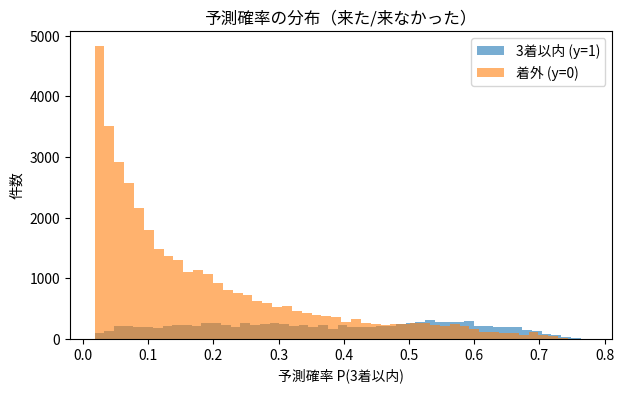

In [13]:
import matplotlib.pyplot as plt

# y と oof_pred を使う（= pred_place）
p = df["pred_place"].values
y = df["y_place"].values

plt.figure(figsize=(7,4))
plt.hist(p[y==1], bins=50, alpha=0.6, label="3着以内 (y=1)")
plt.hist(p[y==0], bins=50, alpha=0.6, label="着外 (y=0)")
plt.xlabel("予測確率 P(3着以内)")
plt.ylabel("件数")
plt.legend()
plt.title("予測確率の分布（来た/来なかった）")
#plt.yscale("log")
plt.show()


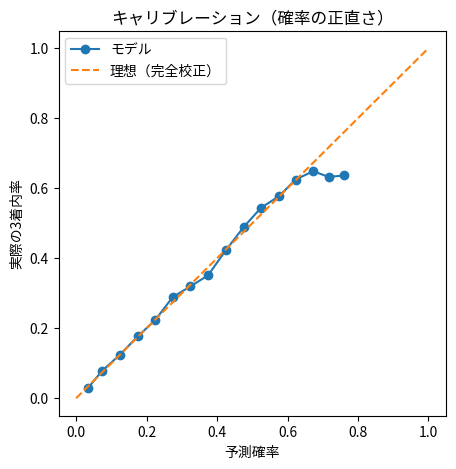

In [22]:
import numpy as np

def calibration_curve_manual(y_true, y_prob, n_bins=20):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    xs, ys = [], []
    for i in range(n_bins):
        mask = bin_ids == i
        if mask.sum() == 0:
            continue
        xs.append(y_prob[mask].mean())
        ys.append(y_true[mask].mean())
    return np.array(xs), np.array(ys)

xs, ys = calibration_curve_manual(y, p, n_bins=20)

plt.figure(figsize=(5,5))
plt.plot(xs, ys, marker="o", label="モデル")
plt.plot([0,1], [0,1], "--", label="理想（完全校正）")
plt.xlabel("予測確率")
plt.ylabel("実際の3着内率")
plt.legend()
plt.title("キャリブレーション（確率の正直さ）")
plt.show()


In [19]:
# 例：任意のレースを1つ選ぶ
sample_race = df["race_id"].iloc[2000]

tmp = (
    df[df["race_id"] == sample_race]
    .sort_values("pred_place", ascending=False)
    [["馬名", "pred_place", "着 順"]]
)

print(tmp)


             馬名  pred_place 着 順
1991  ナンヨークリスタル    0.498391   3
1990    ハヤテノツバサ    0.491262   2
1989    サードウインド    0.446379   1
1992   ライヴドライバー    0.356274   4
1999     キボウノホシ    0.256795  11
1993      ペレグリン    0.239707   5
1996  ミッキースピナッチ    0.237444   8
1998   ラブミーナッソー    0.161133  10
1994     スイッチオン    0.106573   6
1997   シャインミラカナ    0.062683   9
1995    アルマロクザン    0.045431   7
2000    ブルーデイジー    0.043978  12


# モデルの保存

In [23]:
# 予測と正解を一緒に保存（最低限これ）
cols_to_save = [
    "race_id", "馬名", "着順", "y_place", "pred_place",
    "人気", "枠番", "馬番", "斤量", "馬体重", "jockey_id", "調教師"
]

# 存在する列だけにする（安全）
cols_to_save = [c for c in cols_to_save if c in df.columns]

out_path = "oof_predictions.csv"
df[cols_to_save].to_csv(out_path, index=False, encoding="utf-8-sig")

print("saved:", out_path)


saved: oof_predictions.csv


In [26]:
models = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups)):
    tr_data = lgb.Dataset(
        X.iloc[tr_idx],
        y.iloc[tr_idx] if hasattr(y, "iloc") else y[tr_idx],
        categorical_feature=cat_features
    )
    va_data = lgb.Dataset(
        X.iloc[va_idx],
        y.iloc[va_idx] if hasattr(y, "iloc") else y[va_idx],
        categorical_feature=cat_features
    )

    model = lgb.train(
        params,
        tr_data,
        valid_sets=[va_data],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
    )

    model.save_model(f"lgb_place_fold{fold}.txt")
    models.append(model)

    oof_pred[va_idx] = model.predict(X.iloc[va_idx])

print("saved fold models: lgb_place_fold0.txt ... lgb_place_fold4.txt")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.425692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.423775
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.422542
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.422525
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.421215
saved fold models: lgb_place_fold0.txt ... lgb_place_fold4.txt


# 次回vscodeあけたとき

In [ ]:
import glob
import lightgbm as lgb
import numpy as np

model_files = sorted(glob.glob("lgb_place_fold*.txt"))
models = [lgb.Booster(model_file=f) for f in model_files]

print("loaded:", model_files)


In [ ]:
pred = np.mean([m.predict(X_new) for m in models], axis=0)


# 前処理関数

In [ ]:
import pandas as pd

FEATURES = ["枠番","馬番","斤量","馬体重","人気","jockey_id","調教師"]
CAT_FEATURES = ["jockey_id","調教師"]

def make_X(df_in: pd.DataFrame) -> pd.DataFrame:
    X = df_in[FEATURES].copy()
    for c in FEATURES:
        if c in CAT_FEATURES:
            X[c] = X[c].fillna("UNKNOWN").astype("category")
        else:
            X[c] = pd.to_numeric(X[c], errors="coerce").fillna(-1)
    return X


In [ ]:
df_new = pd.read_csv("future_race.csv")
X_new = make_X(df_new)
pred = model.predict(X_new)  # or fold平均


# 人気（オッズ）の情報を抜いても同じようになるのか？

In [28]:
import numpy as np
import pandas as pd

# 人気なし特徴量
features_no_pop = ["枠 番","馬 番","斤量","馬体重","jockey_id","調教師"]
cat_features = ["jockey_id","調教師"]  # ここは同じでOK

# X, y, groups を作り直す（dfにこれら列がある前提）
X2 = df[features_no_pop].copy()
y2 = df["y_place"].copy()
groups2 = df["race_id"].copy()

# 型と欠損を揃える（学習時と同じルール）
for c in features_no_pop:
    if c in cat_features:
        X2[c] = X2[c].fillna("UNKNOWN").astype("category")
    else:
        X2[c] = pd.to_numeric(X2[c], errors="coerce").fillna(-1)

print("X2 shape:", X2.shape, "n_races:", groups2.nunique(), "y mean:", y2.mean())


X2 shape: (47122, 6) n_races: 3402 y mean: 0.2167989474130979


In [29]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "seed": 42,
    "verbosity": -1,
}

gkf = GroupKFold(n_splits=5)
oof_pred2 = np.zeros(len(X2))

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X2, y2, groups2)):
    print(f"\n===== Fold {fold} (no 人気) =====")

    tr_data = lgb.Dataset(
        X2.iloc[tr_idx], y2.iloc[tr_idx],
        categorical_feature=cat_features
    )
    va_data = lgb.Dataset(
        X2.iloc[va_idx], y2.iloc[va_idx],
        categorical_feature=cat_features
    )

    model = lgb.train(
        params, tr_data,
        valid_sets=[va_data],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
    )

    oof_pred2[va_idx] = model.predict(X2.iloc[va_idx])

print("\nCV LogLoss (no 人気):", log_loss(y2, oof_pred2))

# dfに保存して比較しやすくする
df["pred_place_no_pop"] = oof_pred2



===== Fold 0 (no 人気) =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.508074

===== Fold 1 (no 人気) =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.507368

===== Fold 2 (no 人気) =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.50669

===== Fold 3 (no 人気) =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.506517

===== Fold 4 (no 人気) =====
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.503311

CV LogLoss (no 人気): 0.5063919738542378


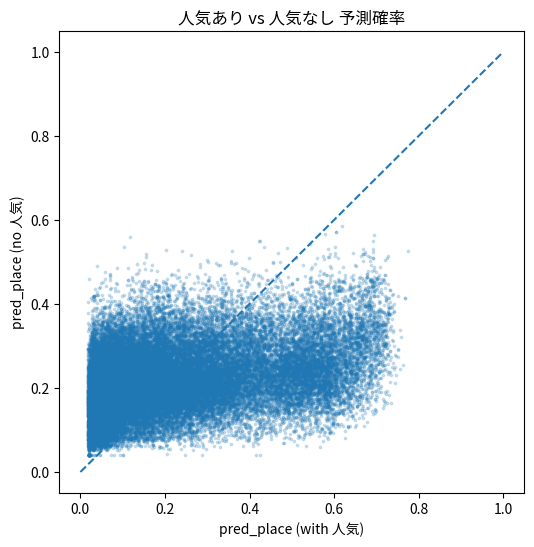

In [30]:
import matplotlib.pyplot as plt

p1 = df["pred_place"].values          # 人気あり（元のOOF）
p2 = df["pred_place_no_pop"].values   # 人気なし

plt.figure(figsize=(6,6))
plt.scatter(p1, p2, s=3, alpha=0.2)
plt.xlabel("pred_place (with 人気)")
plt.ylabel("pred_place (no 人気)")
plt.title("人気あり vs 人気なし 予測確率")
plt.plot([0,1],[0,1], linestyle="--")
plt.show()
